In [187]:
import json
from qutip import *
import numpy as np
import scipy
import cmath
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import itertools
from numpy.random import seed
from numpy.random import rand
from itertools import product
from scipy.misc import derivative
from scipy import optimize
from functools import wraps
from time import time
from scipy.optimize import minimize
from matplotlib import gridspec


In [33]:
#Wrapper to time functions
def timing(f):
    @wraps(f)
    def wrap(*args, **kw):
        ti = time()
        result = f(*args, **kw)
        tf = time()
        t = tf-ti
        return result, t
    return wrap

In [34]:
#Make basis and get sz values
def operatorCreation(N):
    #operator definitionis
    si = qeye(2)
    sx = 0.5*sigmax()
    sy = 0.5*sigmay()
    sz = 0.5*sigmaz()

    sx_list = []
    sy_list = []
    sz_list = []
    

    for n in range(N):
        op_list = []
        for m in range(N):
            op_list.append(si)

        op_list[n] = sx
        sx_list.append(tensor(op_list))

        op_list[n] = sy
        sy_list.append(tensor(op_list))

        op_list[n] = sz
        sz_list.append(tensor(op_list))
        
        op_list[n] = si
    id = tensor(op_list)
        
    return sx_list, sy_list, sz_list,id

In [35]:
#Construct Hamiltonian
def hamiltonian(N,B,A0):
    sx_list = operatorCreation(N)[0]
    sy_list = operatorCreation(N)[1]
    sz_list = operatorCreation(N)[2]
    H = B*sz_list[0] 
    for n in range(N-1):
        H += A0*sz_list[0]*sz_list[n+1] + A0*sx_list[0]*sx_list[n+1] + A0*sy_list[0]*sy_list[n+1]
    return H

In [36]:
#Check if dengerate
def CheckDegenerate(H):
    estates = H.eigenstates()
    lowState = estates[0][0]
    secLowState = estates[0][1]
    if (abs(lowState-secLowState))<= 1e-10:
        return True
    else:
        return False

In [37]:
#Get Ground State Energy and Wavefuntion
class GroundState:
    
    def __init__(self, N, B, A0):
        self.hamiltonian = hamiltonian(N, B, A0)
     
    @timing
    def __call__(self):
        #find ground state
        H = self.hamiltonian
        groundState= H.groundstate()
        return groundState[0],groundState[1]

In [38]:
#Make basis and get sz values
def basisCreation(N):
    sz_list = operatorCreation(N)[2]
    Sbasis = []
    basisState = []
   
    for j in range(2):
        basisState.append(basis(2,j))
    b = itertools.product(basisState,repeat=N)
    basisTensor = list(b)
    #makes Sbasis the correct dimesion of Qobj
    for i in range(2**N):
        c = basisTensor[i][0]
        for j in range(N-1):
            c = tensor(c,basisTensor[i][j+1])
        Sbasis.append(c)

    
    #get sz values for basis states
    sz = np.zeros((2**N,N), dtype = complex)
    a = [[1 for j in range(N)] for i in range(2**N)]
    for i in range(2**N):
        for j in range(N):
            #matrix element <bra|Sz|ket>
            sz[i][j] = sz_list[j].matrix_element(Sbasis[i],Sbasis[i])
    return Sbasis, sz


In [39]:
#get randomized RBM parameters (between zero and 1)
def ranRBMpar(N,M):
    par = np.random.rand(2*(N+M+N*M))
    return par

In [40]:
#Function to give RBM wavefuntion
def RBM_ansatz(par,N, M):
    Sbasis = basisCreation(N)[0]
    sz = basisCreation(N)[1]
    #make parmeters complex
    num = N+M+N*M
    parC = np.vectorize(complex)(par[:num],par[num:])
    a = parC[:N]
    b = parC[N:N+M]
    W = parC[N+M:].reshape(M,N)
    expTerm = np.zeros(2**N, dtype = complex)
    coshTerm = np.zeros((M,2**N), dtype = complex)
    hidProduct = np.zeros(2**N, dtype = complex)
    psiMValues = np.zeros(2**N, dtype = complex)
    psiM = 0*Sbasis[0]

    for i in range(2**N):
        for m in range(M):
            coshTerm[m][i] = 2*np.cosh(np.dot(W[m],sz[i]) + b[m])
    hidProduct = np.prod(coshTerm, axis = 0) 
    
    for i in range(2**N):
        expTerm[i] = np.exp(np.dot(a,sz[i]))
        psiMValues[i] = expTerm[i]*hidProduct[i]
        psiM += psiMValues[i]*Sbasis[i]
    psiNorm = psiM.unit()
    return psiNorm


In [41]:
#Variation Energy Definition
def varEnergy(par,N, M, H):
    psiM = RBM_ansatz(par,N, M)
    E = expect(H,psiM)
    norm = psiM.norm()**2
    Enorm = E/norm
    return Enorm

In [42]:
#Energy Partials
def gradEnergy(par,N, M,H):
    eps = 0.001
    return optimize.approx_fprime(par,varEnergy,eps, N, M,H)

In [43]:
#Gradient Descent
class GradDescent:
    
    def __init__(self, N, B, A0):
        H = hamiltonian(N, B, A0)
        isDeg = CheckDegenerate(H)
        if (isDeg == True):
            raise ValueError("Hamiltonian has degenerate ground state")
        else:
            self.hamiltonian = H
     
    @timing 
    def __call__(self, N, M):
        par = ranRBMpar(N,M)
        H = self.hamiltonian
        min = scipy.optimize.fmin_cg(varEnergy,par,args= (N,M,H),gtol = 1e-04, full_output=True, retall = True, disp=True)
        #Ground State
        found_gs = RBM_ansatz(min[0],N, M)
        found_gs = found_gs.unit()
        #Ground State Energy
        found_gsEnergy =varEnergy(min[0], N, M,H)

        return min, found_gs, found_gsEnergy  

In [145]:
#NelderMead
class NelderMead:
    
    def __init__(self, N, B, A0):
        H = hamiltonian(N, B, A0)
        isDeg = CheckDegenerate(H)
        if (isDeg == True):
            raise ValueError("Hamiltonian has degenerate ground state")
        else:
            self.hamiltonian = H
     
    @timing 
    def __call__(self, N, M):
        par = ranRBMpar(N,M)
        H = self.hamiltonian
        min = minimize(varEnergy, par,args= (N,M,H), method='nelder-mead', options={'disp': True})
        #Ground State
        found_gs = RBM_ansatz(min.x,N, M)
        found_gs = found_gs.unit()
        #Ground State Energy
        found_gsEnergy =varEnergy(min.x, N, M,H)

        return min, found_gs, found_gsEnergy  

In [166]:
#BFGS
class BFGS:
    
    def __init__(self, N, B, A0):
        H = hamiltonian(N, B, A0)
        isDeg = CheckDegenerate(H)
        if (isDeg == True):
            raise ValueError("Hamiltonian has degenerate ground state")
        else:
            self.hamiltonian = H
     
    @timing 
    def __call__(self, N, M):
        par = ranRBMpar(N,M)
        H = self.hamiltonian
        min = minimize(varEnergy, par,args= (N,M,H), method='BFGS', options={'disp': True})
        #Ground State
        found_gs = RBM_ansatz(min.x,N, M)
        found_gs = found_gs.unit()
        #Ground State Energy
        found_gsEnergy =varEnergy(min.x, N, M,H)

        return min, found_gs, found_gsEnergy  

In [168]:
#Newton-CG
class NewtonCG:
    
    def __init__(self, N, B, A0):
        H = hamiltonian(N, B, A0)
        isDeg = CheckDegenerate(H)
        if (isDeg == True):
            raise ValueError("Hamiltonian has degenerate ground state")
        else:
            self.hamiltonian = H
     
    @timing 
    def __call__(self, N, M):
        par = ranRBMpar(N,M)
        H = self.hamiltonian
        min = minimize(varEnergy, par,args= (N,M,H), method='Newton-CG', options={'disp': True})
        #Ground State
        found_gs = RBM_ansatz(min.x,N, M)
        found_gs = found_gs.unit()
        #Ground State Energy
        found_gsEnergy =varEnergy(min.x, N, M,H)

        return min, found_gs, found_gsEnergy  

In [146]:
#Error Calculation
def err(found_gs,gs,found_gsEnergy,gsEnergy):
    engErr = np.abs(found_gsEnergy-gsEnergy)
    waveFunctionErr = found_gs.dag()*gs
    waveFunctionErr = 1-waveFunctionErr.norm()
    
    return engErr,waveFunctionErr


## Other Minimization Testing

In [103]:
N=2
M=1
B = np.pi
A0 = 1

In [104]:
par = ranRBMpar(N,M)
H = hamiltonian(N, B, A0)
mingd = scipy.optimize.fmin_cg(varEnergy,par,args= (N,M,H),gtol = 1e-04, full_output=True, retall = True, disp=True)

Optimization terminated successfully.
         Current function value: -1.820793
         Iterations: 6
         Function evaluations: 276
         Gradient evaluations: 23


In [105]:
print(mingd[0])

[-4.38817024  3.51299911  3.64298371 -2.51756552  4.3200762  -0.5774178
  1.69659326 -2.45267698 -2.52820069  4.35775766]


In [152]:
par = ranRBMpar(N,M)
H = hamiltonian(N, B, A0)
minop = minimize(varEnergy, par,args= (N,M,H), method='BFGS', options={'disp': True})
print(minop.x)


Optimization terminated successfully.
         Current function value: -1.898452
         Iterations: 41
         Function evaluations: 504
         Gradient evaluations: 42
[ 1.56303677  7.66682177 -2.12074572 -8.63589003 15.72077953 -2.19685516
  3.58407658 -1.31966999  3.64452953  2.84069266]


In [153]:
opState = RBM_ansatz(minop.x,N, M)
print(opState)
opEng = varEnergy(minop.x,N, M, H)
print(opEng)
groundState = GroundState(N,B,A0)
ed = groundState()
edEng = ed[0][0]
edState = ed[0][1]
print(edState)
print(edEng)
Error = err(opState,edState ,opEng,edEng)
print(Error)

Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
Qobj data =
[[-7.08586459e-04+3.73964135e-04j]
 [-6.00373187e-02-1.41245704e-01j]
 [ 3.86550307e-01+9.09408264e-01j]
 [-4.26667028e-06-3.79589526e-06j]]
-1.898451767168222
Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
Qobj data =
[[ 0.        ]
 [-0.15347555]
 [ 0.98815245]
 [ 0.        ]]
-1.8984541547378078
(2.387569585815541e-06, 3.209883944199632e-07)


In [72]:
optimize = Optimize(N,B,A0)
op = optimize(N,M)


Optimization terminated successfully.
         Current function value: -1.820796
         Iterations: 289
         Function evaluations: 694


## Comparison Histograms

In [217]:
#Parameter definition 
N= 2
M=1
B = np.pi
A0 = 1

gdResults = [] #gives ground state estimation at each iteration of gd
gdState = []
gdTime = []
gdEngErr = []
gdStateErr = []

edState = []
edTime = []
ActualEng = []

nmState = []
nmTime = []
nmEngErr = []
nmStateErr = []

nwState = []
nwTime = []
nwEngErr = []
nwStateErr = []

bfState = []
bfTime = []
bfEngErr = []
bfStateErr = []

hisIt = np.arange(50)

In [218]:
for i in range(len(hisIt)):
    #gradient descent
    gradDescent = GradDescent(N, B, A0)
    gd = gradDescent(N, M)
    gdResults.append(gd)
    gdState.append(gd[0])
    gdTime.append(gd[1])
    
    
    #exact diagonalization 
    groundState = GroundState(N,B,A0)
    ed = groundState()
    edState.append(ed[0])
    edTime.append(ed[1])
    
    #Nelder Mead
    nelderMead = NelderMead(N,B,A0)
    nm = nelderMead(N,M)
    nmState.append(nm[0])
    nmTime.append(nm[1])
    
    #BFGS
    bfgs = BFGS(N,B,A0)
    bf = bfgs(N,M)
    bfState.append(bf[0])
    bfTime.append(bf[1])
    
    #Newton-CG
    #newtonCG = NewtonCG(N,B,A0)
    #nw = newtonCG(N,M)
    #nwState.append(nw[0])
    #nwTime.append(nw[1])
    
    
    #Error
    gdEngTemp = gd[0][2]
    nmEngTemp = nm[0][2]
    bfEngTemp = bf[0][2]
    edEngTemp = ed[0][0]
    #nwEngTemp = nw[0][2]
    
    ActualEng.append(edEngTemp)
    gdStateTemp = gd[0][1]
    edStateTemp = ed[0][1]
    nmStateTemp = nm[0][1]
    bfStateTemp = bf[0][1]
    #nwStateTemp = nw[0][1]
    
    gdErrTemp = err(gdStateTemp,edStateTemp,gdEngTemp,edEngTemp)
    nmErrTemp = err(nmStateTemp,edStateTemp,nmEngTemp,edEngTemp)
    bfErrTemp = err(bfStateTemp,edStateTemp,bfEngTemp,edEngTemp)
    #nwErrTemp = err(nwStateTemp,edStateTemp,nwEngTemp,edEngTemp)
    
    gdEngErr.append(gdErrTemp[0])
    gdStateErr.append(gdErrTemp[1])
    nmEngErr.append(nmErrTemp[0])
    nmStateErr.append(nmErrTemp[1])
    bfEngErr.append(bfErrTemp[0])
    bfStateErr.append(bfErrTemp[1])
    #nwEngErr.append(nwErrTemp[0])
    #nwStateErr.append(nwErrTemp[1])


Optimization terminated successfully.
         Current function value: -1.898454
         Iterations: 20
         Function evaluations: 504
         Gradient evaluations: 42
Optimization terminated successfully.
         Current function value: -1.820796
         Iterations: 220
         Function evaluations: 462
Optimization terminated successfully.
         Current function value: -1.898454
         Iterations: 36
         Function evaluations: 456
         Gradient evaluations: 38
Optimization terminated successfully.
         Current function value: -1.820738
         Iterations: 7
         Function evaluations: 300
         Gradient evaluations: 25
Optimization terminated successfully.
         Current function value: -1.898454
         Iterations: 54
         Function evaluations: 744
         Gradient evaluations: 62
Optimization terminated successfully.
         Current function value: -1.898454
         Iterations: 17
         Function evaluations: 420
         Gradient evalua

Optimization terminated successfully.
         Current function value: -1.820790
         Iterations: 15
         Function evaluations: 240
         Gradient evaluations: 20
Optimization terminated successfully.
         Current function value: -1.898449
         Iterations: 24
         Function evaluations: 684
         Gradient evaluations: 57
Optimization terminated successfully.
         Current function value: -1.820796
         Iterations: 213
         Function evaluations: 476
Optimization terminated successfully.
         Current function value: -1.898454
         Iterations: 29
         Function evaluations: 360
         Gradient evaluations: 30
Optimization terminated successfully.
         Current function value: -1.898434
         Iterations: 31
         Function evaluations: 1152
         Gradient evaluations: 96
Optimization terminated successfully.
         Current function value: -1.898454
         Iterations: 939
         Function evaluations: 1484
Optimization termina

Optimization terminated successfully.
         Current function value: -1.898451
         Iterations: 41
         Function evaluations: 552
         Gradient evaluations: 46
Optimization terminated successfully.
         Current function value: -1.898454
         Iterations: 24
         Function evaluations: 672
         Gradient evaluations: 56
Optimization terminated successfully.
         Current function value: -1.898454
         Iterations: 895
         Function evaluations: 1293
Optimization terminated successfully.
         Current function value: -1.820795
         Iterations: 18
         Function evaluations: 240
         Gradient evaluations: 20
Optimization terminated successfully.
         Current function value: -1.820735
         Iterations: 6
         Function evaluations: 276
         Gradient evaluations: 23
Optimization terminated successfully.
         Current function value: -1.820796
         Iterations: 211
         Function evaluations: 473
Optimization terminate

In [219]:
stateErr = [gdStateErr, nmStateErr, bfStateErr]
engErr = [gdEngErr, nmEngErr, bfEngErr]
runTime = [gdTime, nmTime, bfTime]

Text(0, 0.5, 'Runtime')

<Figure size 576x396 with 0 Axes>

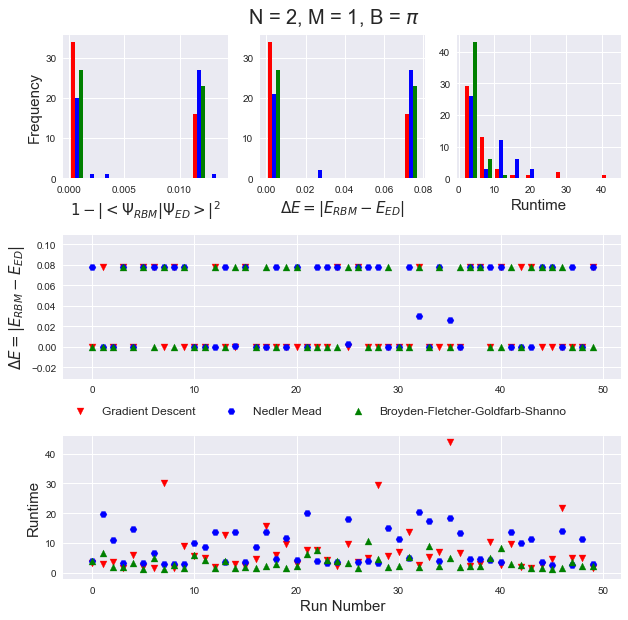

In [256]:


labels = ['Gradient Descent','Nedler Mead', 'Broyden-Fletcher-Goldfarb-Shanno']
colors = ['red','blue','green']
plt.figure(constrained_layout=True)
plt.figure(figsize=(10,10))
ttl = plt.suptitle("N = 2, M = 1, B = $\pi$",size =20)
gs = gridspec.GridSpec(ncols=3, nrows=3, hspace = 0.4)
ttl.set_position([.5, 0.92])



ax1 = plt.subplot(gs[0, 0])
ax1 .hist(stateErr, bins=10, label=labels, color=colors) 
ax1 .set_xlabel("$1-|<\Psi_{RBM}|\Psi_{ED}>|^2$",size = 15)
ax1.set_ylabel("Frequency",size = 15)



ax2 = plt.subplot(gs[0, 1])
ax2.hist(engErr, bins=10, color=colors) 
ax2.set_xlabel("$\Delta E = |E_{RBM}-E_{ED}|$",size = 15)



ax3 = plt.subplot(gs[0, 2])
ax3.hist(runTime, bins=10,color=colors) 
ax3.set_xlabel("Runtime",size = 15)


ax4 = plt.subplot(gs[1, :])
ax4.scatter(hisIt,engErr[0],color=colors[0],marker ='v') 
ax4.scatter(hisIt,engErr[1],color=colors[1],marker ='H') 
ax4.scatter(hisIt,engErr[2],color=colors[2],marker = '^') 
ax4 .set_ylabel("$\Delta E = |E_{RBM}-E_{ED}|$", size = 15)


plt.legend(labels, loc = (0, -0.3),fontsize = 12,ncol=3)

ax5 = plt.subplot(gs[2, :])
ax5.scatter(hisIt,runTime[0],color=colors[0],marker ='v') 
ax5.scatter(hisIt,runTime[1],color=colors[1],marker ='H') 
ax5.scatter(hisIt,runTime[2],color=colors[2],marker = '^') 
ax5.set_xlabel("Run Number",size = 15)
ax5 .set_ylabel("Runtime", size = 15)










